<a href="https://colab.research.google.com/github/Jeremiah-Bachtin/comp1884-group6-weather-anomaly-detection-system/blob/main/Marie%3A%20xai_db_tpa_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### XAI Technique 1: Tree Path Analysis

### This notebook contains dashboard ready code for plots and natural language summaries

Install required python libraries

In [ ]:
pip install scikit-learn==1.3.2


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.tree import _tree
from sklearn.tree import plot_tree
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load sequence and inference data

In [ ]:
seq_start_times = np.load('/content/drive/MyDrive/Data Science MSC/v2XAIHANDOFF/xai_handoff_v2/lstm_sequences/seq_start_times_train.npy',allow_pickle=True)
df = pd.read_csv('/content/drive/MyDrive/Data Science MSC/v2XAIHANDOFF/xai_handoff_72_hr_inference/inference/inference_20250531_1700.csv')

Load the Isolation Forest model

In [ ]:
if_model = joblib.load('/content/drive/MyDrive/Data Science MSC/v2XAIHANDOFF/xai_handoff_v2/models/if_model.joblib')

### Data exploration

Data summary

In [ ]:
print(df.head())

                  date  temperature_2m  surface_pressure  precipitation  \
0  2025-05-31 17:00:00            23.0            1011.4            0.0   
1  2025-05-31 18:00:00            21.9            1011.2            0.0   
2  2025-05-31 19:00:00            21.1            1010.8            0.0   
3  2025-05-31 20:00:00            20.1            1010.9            0.0   
4  2025-05-31 21:00:00            18.7            1011.7            0.0   

   wind_speed_10m  precip_log  wind_smoothed  temperature_2m_z  \
0            24.1         0.0      24.100000          1.981413   
1            24.8         0.0      24.450000          1.748538   
2            25.2         0.0      24.700000          1.579173   
3            15.8         0.0      21.933333          1.367468   
4            18.4         0.0      19.800000          1.071081   

   surface_pressure_z    wind_r  ...      hour_cos  month_sin  month_cos  \
0           -0.440185  1.727468  ... -2.588190e-01        0.5  -0.866025   


## Tree Path Analysis


In [ ]:
if_features = ['temperature_2m_z', 'surface_pressure_z', 'wind_r', 'precip_z_12h', 'precip_z_24h']

Tree structure

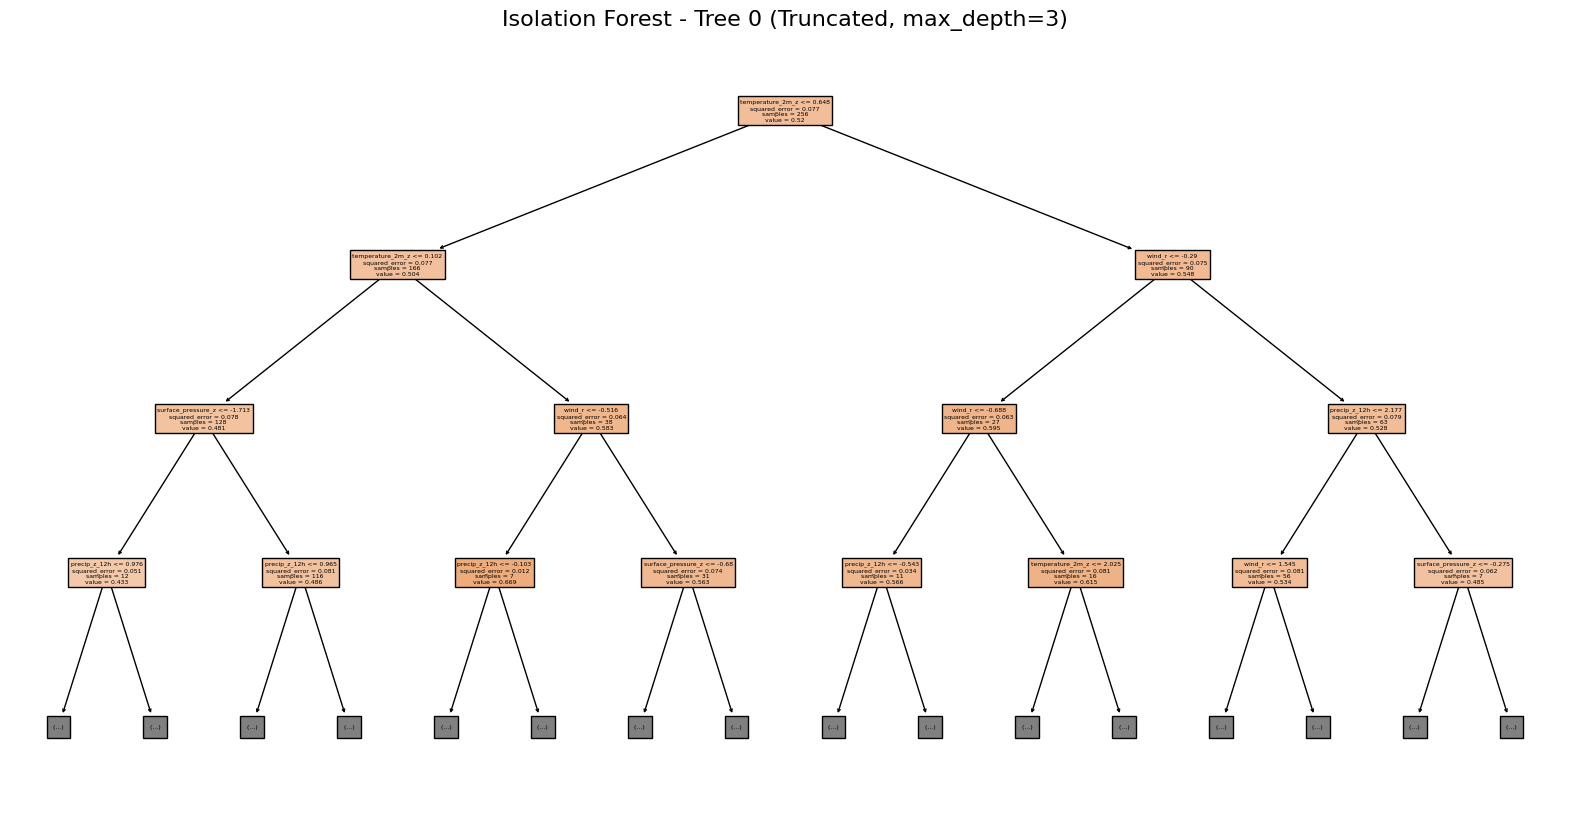

In [ ]:
tree_index_to_plot = 0 # first tree in the ensemble- change index to change which tree is visualisaed

if tree_index_to_plot < len(if_model.estimators_):
    selected_tree = if_model.estimators_[tree_index_to_plot]

    plt.figure(figsize=(20, 10))
    plot_tree(selected_tree, feature_names=if_features, filled=True, max_depth=3)  # Limit max_depth for readability

    plt.title(f"Isolation Forest - Tree {tree_index_to_plot} (Truncated, max_depth=3)", fontsize=16)
    plt.show()
else:
    print(f"Error: Tree index {tree_index_to_plot} is out of bounds. The model has {len(if_model.estimators_)} trees (indices 0 to {len(if_model.estimators_)-1}).")


Path length of a single sample

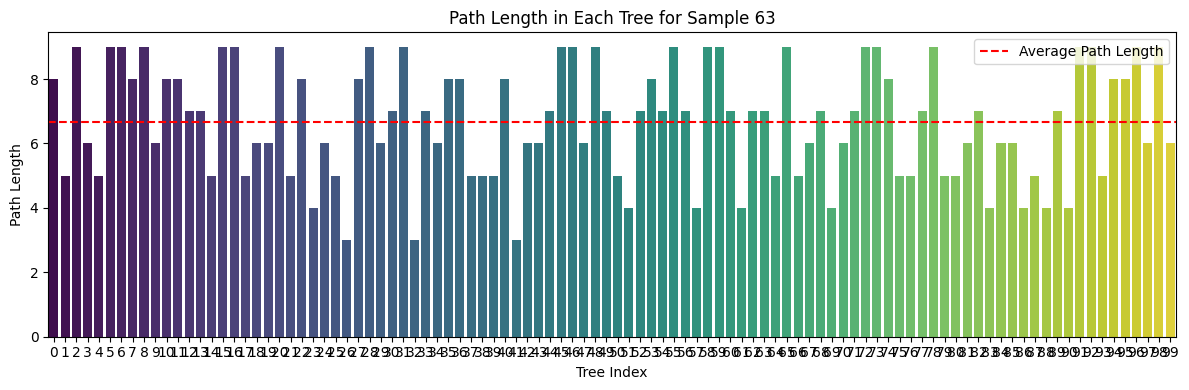

In [ ]:
sample_index = 63 # change to select a different sample

# Select the sample data for the Isolation Forest features
X_sample = df[if_features].iloc[[sample_index]]

# Calculate the path length for this sample in each tree
path_lengths = []
for tree in if_model.estimators_:
    # tree.decision_path returns a sparse matrix indicating the path nodes
    path = tree.decision_path(X_sample)
    # number of nodes visited (number of non-zero entries in the sparse matrix)
    path_lengths.append(path.nnz)

# Now path_lengths is defined and contains the path length for the sample in each tree

plt.figure(figsize=(12, 4))
sns.barplot(x=np.arange(len(path_lengths)), y=path_lengths, palette="viridis")
plt.axhline(np.mean(path_lengths), color='red', linestyle='--', label='Average Path Length')
plt.xlabel("Tree Index")
plt.ylabel("Path Length")
plt.title(f"Path Length in Each Tree for Sample {sample_index}")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# calculating and storing decision paths for each sample through each tree in the Isolation Forest
paths_per_tree = []

for tree in if_model.estimators_:

    snapshot_df = df[if_features]
    path_matrix_tree = tree.decision_path(snapshot_df)
    paths_per_tree.append(path_matrix_tree)

print(f"Number of trees processed: {len(paths_per_tree)}")
print(f"Shape of path matrix for the first tree: {paths_per_tree[0].shape}")

Number of trees processed: 100
Shape of path matrix for the first tree: (72, 169)


In [ ]:
# identifying which features were used in splits

def tree_path_features(tree, x):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold

    node = 0
    path_features = []

    while tree_.feature[node] != _tree.TREE_UNDEFINED:
        split_feature = feature[node]
        path_features.append(split_feature)
        if x[split_feature] <= threshold[node]:
            node = tree_.children_left[node]
        else:
            node = tree_.children_right[node]

    return path_features


### XAI visualisations & natural language summaries

Feature importance


Represents how frequently each feature was used for splitting decisions along paths taken by analyzed samples

In [ ]:
# calculating and visualising TPA scores for each sample in the snapshot

# Dictionary to store feature counts for each sample
all_sample_feature_counts = {}

for i, row in snapshot_df.iterrows():
    # Dictionary to store feature counts for the current sample
    feature_counts = {}

    # Iterate through each tree in the Isolation Forest model
    for estimator in if_model.estimators_:
        features_used = tree_path_features(estimator, row[if_features].values)

        # Count how many times each feature's index was used in the path
        for f in features_used:

            fname = if_features[f]
            feature_counts[fname] = feature_counts.get(fname, 0) + 1

    # Store the feature counts for the current sample, indexed by the original sample index
    all_sample_feature_counts[i] = feature_counts

# Convert the dictionary of feature counts into a DataFrame
# Each row corresponds to a sample (original index), columns are features, values are counts
tpa_df = pd.DataFrame.from_dict(all_sample_feature_counts, orient='index')

tpa_df = tpa_df.fillna(0)

# Normalize the counts: Divide the counts for each feature by the total number of trees
# This gives the proportion of trees where a feature was used in the sample's path
tpa_df = tpa_df / len(if_model.estimators_)



Generating natural language summaries and visualisations for each sample based on TPA scores

In [ ]:


# Define output directory for plots
plot_output_dir = "/content/drive/MyDrive/Data Science Group Project/Current_Version_XAI_Outputs/Plots"
# os.makedirs(plot_output_dir, exist_ok=True)

# Initialize lists to hold summaries and plot file paths
tpa_summaries = []
tpa_plot_paths = []

for original_sample_index in snapshot_df.index:

    label = df.loc[original_sample_index, "anomaly_label"]

    if label.lower() == "compound anomaly":
        label_description = (
            "🔺 This sample was flagged as a **Compound Anomaly**, meaning both sub-models detected unusual patterns. "
            "This may suggest a more credible anomaly, but should still be reviewed in context."
        )
        what_happened = (
            "The sample exhibits multiple unusual characteristics detected by both models."
        )
        why_happened = (
            "The combined flags indicate consistent unusual activity across different feature subsets."
        )
        what_to_do = (
            "Consider prioritizing this sample for further investigation or mitigation."
        )
    elif label.lower() == "normal":
        label_description = (
            "✅ This sample was classified as **Normal**, meaning the model found no significant deviations in the data."
        )
        what_happened = "The sample shows normal behavior with no flagged anomalies."
        why_happened = "The features fell within expected ranges based on training data."
        what_to_do = "No immediate action is required."
    else:
        label_description = (
            f"⚠️ This sample was labeled as **{label}**, flagged by only one detection model."
        )
        what_happened = (
            "The model identified some unusual patterns but only from a single perspective."
        )
        why_happened = (
            "This could be due to isolated irregularities or potential model sensitivity."
        )
        what_to_do = (
            "Further review is advised to confirm whether this is a true anomaly."
        )

    if original_sample_index in tpa_df.index:
        sample_tpa_scores = tpa_df.loc[original_sample_index]
        sample_tpa_scores_sorted = sample_tpa_scores.sort_values(ascending=False)

        # Generate summary text
        top_features = sample_tpa_scores_sorted.head(2)
        summary = (
            f"🧠 Tree Path Analysis shows these top features influenced the model's decision:\n"
        )
        for feature, score in top_features.items():
            summary += f"- **{feature.replace('_', ' ').capitalize()}** (importance: {score:.2f})\n"

        summary += (
            f"\nWhat happened?\n{what_happened}\n\n"
            f"Why did it happen?\n{why_happened}\n\n"
            f"What can we do about it?\n{what_to_do}\n\n"
            f"{label_description}"
        )

        # Save summary text for this sample
        tpa_summaries.append(summary)

        # Create and save plot
        plt.figure(figsize=(10, 6))
        sample_tpa_scores_sorted.plot(kind="barh", color="teal")
        plt.title(f"Tree Path Analysis\nSample Index: {original_sample_index} | Label: {label}", fontsize=14)
        plt.xlabel("Normalized Split Count (Across Trees)", fontsize=12)
        plt.ylabel("Feature", fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.tight_layout()

        plot_filename = f"tpa_sample_{original_sample_index}.png"
        plot_filepath = os.path.join(plot_output_dir, plot_filename)
        plt.savefig(plot_filepath)
        plt.close()

        tpa_plot_paths.append(plot_filepath)

    else:
        print(f"⚠️ Error: Sample index {original_sample_index} not found in TPA results.")
        tpa_summaries.append("")
        tpa_plot_paths.append("")

# Append new columns to snapshot data
df.loc[snapshot_df.index, "tpa_summary"] = tpa_summaries
df.loc[snapshot_df.index, "tpa_plot_path"] = tpa_plot_paths

# Save to CSV
output_csv_path = "/content/drive/MyDrive/Data Science Group Project/Current_Version_XAI_Outputs/TPA.csv"
df.to_csv(output_csv_path, index=False)
print(f"✅ Updated CSV saved to: {output_csv_path}")


✅ Updated CSV saved to: /content/drive/MyDrive/Data Science Group Project/Current_Version_XAI_Outputs/TPA.csv
